 计算机视觉（24春）作业1-5（30分）
---

## 题目: 相机标定实验
- 有一个3D空间中的棋盘格平面，大小为8x8，边长为1个单位长度。假设棋盘格平面位于世界坐标系中`z=0`的平面。
- 同时给你提供一个虚拟相机（理想相机，参数仅包含焦距和主点坐标），能够获得3维棋盘格的二维图像，大小为`400x400`，你可以移动它来获得不同的观察角度下的棋盘格平面的图像（简化为棋盘格角点图像）。
- 请你自行移动相机，获得多个不同角度下的棋盘格平面的图像，利用这些点的坐标，实现相机的标定。

---

### 环境配置见作业HW1-4

---

## 相机模型和3D棋盘格模型

- 以下的代码块里包含一个实现好的相机模型和3D棋盘格模型，你可以直接运行它们来实现相机标定。


In [29]:
import numpy as np
import cv2

"""相机模型"""
class CameraModel(object):
    dft_configs = {
        "fx": 200,
        "fy": 200,
        "cx": 200,
        "cy": 200,
        "yaw": 0, # degrees
        "pitch": 0, # degrees
        "roll": 0, # degrees
        "x": 0, # translation
        "y": 0,
        "z": 10,
    }
    def __init__(self, configs={}) -> None:
        self.configs = {**self.dft_configs, **configs}
        self.fx = self.configs["fx"]
        self.fy = self.configs["fy"]
        self.cx = self.configs["cx"]
        self.cy = self.configs["cy"]
        self.K = np.array([[self.fx, 0, self.cx], [0, self.fy, self.cy], [0, 0, 1]])

        self.yaw = self.configs["yaw"]
        self.pitch = self.configs["pitch"]
        self.roll = self.configs["roll"]
        self.R = self._get_rotation_matrix(self.yaw, self.pitch, self.roll)

        self.x = self.configs["x"]
        self.y = self.configs["y"]
        self.z = self.configs["z"]
        self.T = np.array([self.x, self.y, self.z])

    def show_K(self):
        print(f"K: {self.K}")
    
    def show_R(self):
        print(f"R: {self.R}")

    def show_T(self):
        print(f"T: {self.T}")

    def _get_rotation_matrix(self, yaw, pitch, roll):
        yaw = np.deg2rad(yaw)
        pitch = np.deg2rad(pitch)
        roll = np.deg2rad(roll)
        Rx = np.array([[1, 0, 0], [0, np.cos(pitch), -np.sin(pitch)], [0, np.sin(pitch), np.cos(pitch)]])
        Ry = np.array([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]])
        Rz = np.array([[np.cos(roll), -np.sin(roll), 0], [np.sin(roll), np.cos(roll), 0], [0, 0, 1]])
        return Rz @ Ry @ Rx

    def project(self, points3D):
        """ Project 3D points to 2D
        Args:
            points3D: 3D points, numpy array of shape (N, 3)
        """
        points3D = points3D.reshape(-1, 3)
        points3D = points3D.T
        points_ = self.R @ points3D + self.T.reshape(-1, 1)
        points_ = self.K @ points_
        points2D = points_ / points_[2, :]
        return points2D[:2, :].T # (N, 2)
    
    def draw(self, points, out_img_path=None):
        """ Draw 2D points on image
        Args:
            points: 2D points, numpy array of shape (N, 2)
        """
        img_W = 2*self.cx
        img_H = 2*self.cy
        img = np.zeros((img_H, img_W, 3), dtype=np.uint8)

        point_num = points.shape[0]
        outside_img_count = 0
        for point in points:
            x, y = point
            x, y = int(x), int(y)
            if 0 <= x < img_W and 0 <= y < img_H:
                img = cv2.circle(img, (x, y), 5, (0, 255, 0), -1)
            else:
                outside_img_count += 1
                print(f"Point ({x}, {y}) is outside the image")
        
        print(f"Outside image count: {outside_img_count}, while total points: {point_num}")

        if out_img_path:
            cv2.imwrite(out_img_path, img)
        
        if outside_img_count > 0: return False
        return True

    def move_x_axis_plus(self, step):
        self.x += step
        self.T = np.array([self.x, self.y, self.z])
    
    def move_y_axis_plus(self, step):
        self.y += step
        self.T = np.array([self.x, self.y, self.z])

    def move_z_axis_plus(self, step):
        self.z += step
        self.T = np.array([self.x, self.y, self.z])

    def rotate_yaw_plus(self, degree):
        self.yaw += degree
        self.R = self._get_rotation_matrix(self.yaw, self.pitch, self.roll)
    
    def rotate_pitch_plus(self, degree):
        self.pitch += degree
        self.R = self._get_rotation_matrix(self.yaw, self.pitch, self.roll)
    
    def rotate_roll_plus(self, degree):
        self.roll += degree
        self.R = self._get_rotation_matrix(self.yaw, self.pitch, self.roll)

    def reset(self):
        self.x = self.configs["x"]
        self.y = self.configs["y"]
        self.z = self.configs["z"]
        self.T = np.array([self.x, self.y, self.z])

        self.yaw = self.configs["yaw"]
        self.pitch = self.configs["pitch"]
        self.roll = self.configs["roll"]
        self.R = self._get_rotation_matrix(self.yaw, self.pitch, self.roll)

### 相机模型的使用方法

**主要成员函数如下：**
- `CameraModel.project(points3D)`: 将3D空间中的点投影到相机平面上;
    - 输入
        - `points3D`：为3D空间中的点，类型为`np.ndarray`，尺寸为`(N,3)`，N为点的个数。
    - 返回值
        - `points2D`: 为2D图像平面上的坐标，类型为`np.ndarray`，尺寸为`(N,2)`。
        
- `CameraModel.draw(points2D, out_img_path=None)`: 在图像上绘制投影点，并检验投影点是否在图像内部;
    - 输入：
        - `points2D`：2D平面上的坐标，类型为`np.ndarray`，尺寸为`(N,2)`。
        - `out_img_path`：保存图像的路径，类型为`str`，默认值为`None`，此时不保存图像。
    - 返回值
        - `True`：表示所有投影点都在图像内部
        - `False`：表示有投影点在图像外部

- `CameraModel.move_<axis_name>_plus(step)`：沿着世界坐标系的坐标轴`axis_name`的正方向移动相机;
    - axis_name: `x_axis`, `y_axis`, `z_axis`
    - 输入
        - `step`：移动的步长，类型为`float` （正负均可）。
    - 返回值
        - 无

- `CameraModel.rotate_<angel_name>(degree)`: 改变相机的旋转角，以相机自身坐标系为参照;
    - 相机自身坐标系的x轴指向右，y轴指向下，z轴指向相机的观察方向。
    - angel_name: 旋转角名称 (因为相机坐标系的轴名字定义，与一般的欧拉角定义不同)
        - `yaw`: 绕y轴旋转
        - `pitch`: 绕x轴旋转
        - `roll`: 绕z轴旋转
    - 输入
        - `degree`：旋转的角度，类型为`float` （单位为度，正负均可）。
    - 返回值
        - 无

- `CameraModel.reset()`: 重置相机的位置和旋转角;

**推荐使用流程为：先移动相机，然后进行投影，得到投影点后用`draw`函数检验点的有效性（在图像内），收集有效投影点集合用以标定**


In [30]:
"""3D 棋盘格模型"""
class chessboard3D(object):
    """
    """
    dft_configs = {
        "square_size": 1,
        "rows": 8,
        "cols": 8,
        "z_plane": 0,
    }

    def __init__(self, configs={}) -> None:
        self.configs = {**self.dft_configs, **configs}
        self.square_size = self.configs["square_size"]
        self.rows = self.configs["rows"]
        self.cols = self.configs["cols"]
        self.z_plane = self.configs["z_plane"]
        self.points = self._generate_points()
    
    def _generate_points(self):
        points = []
        for row in range(self.rows):
            for col in range(self.cols):
                points.append([col*self.square_size, row*self.square_size, self.z_plane])
        return np.array(points) # (N, 3)

    def return_points(self):
        return self.points

### 3维棋盘格模型的使用方法

**主要成员函数如下：**
- `ChessboardModel.return_points()`: 获取3D棋盘格模型的角点坐标;
    - 返回值
        - `points3D`：为3D空间中的点，类型为`np.ndarray`，尺寸为`(N,3)`，N为点的个数。

---
## 相机标定的实现

在运行完上述的代码块后，你需要在下面的代码块中实现相机的标定，并用Markdown块完成实验报告。

**实现及报告要求：**

- 相机的标定可以使用opencv库中的函数`cv2.calibrateCamera`，也可以自己实现DLT算法（可酌情加分）。

- OpenCV相机标定可参考：https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

- 请输出最后得到的相机内参数，包括焦距、主点坐标。
    
- 开放题回答：
    - 请尝试不同的相机移动方式，观察标定结果的差异，尝试总结相机移动的最佳策略。
    - 尝试不同次数的二维点投影，观察标定结果的差异，尝试总结标定所用的图像数量（即二维投影点集合的数量）的最佳策略。（越多越好？）

**评分标准：**
- 实现相机标定的正确性（15分）
- 相机参数的精度（5分）
- 开放题的回答（5+5分）

---

以下为答题区域，可以使用多个代码块和markdown块。

## 标定相机
在这一部分，我们选择使用 `cv2.calibrateCamera` 函数直接进行相机标定。我们首先尝试随意选取几组些相机的位置和姿态，尝试进行标定，并计算误差。

In [31]:
def get_result(params_list, verbose = False):
    camera = CameraModel()
    chessboard = chessboard3D()
    points3D = chessboard.return_points()
    points2D = []
    first = True
    
    if not os.path.exists("pics"):
        os.makedirs("pics", exist_ok = True)


    for i in range(len(params_list)):
        parms = params_list[i]
        camera.move_x_axis_plus(parms["x_axis"])
        camera.move_y_axis_plus(parms["y_axis"])
        camera.move_z_axis_plus(parms["z_axis"])
        camera.rotate_yaw_plus(parms["yaw"])
        camera.rotate_pitch_plus(parms["pitch"])
        if first:
            points2D = camera.project(points3D).tolist()
            camera.draw(np.array(points2D), "pics/out{}.png".format(i))
            first = False
        else:
            new = camera.project(points3D).tolist()
            camera.draw(np.array(new), "pics/out{}.png".format(i))
            points2D = points2D + camera.project(points3D).tolist()
        camera.reset()
        


    points3D = points3D.tolist() * len(params_list)

    # 计算行数
    rows = len(params_list) // 5 + (1 if len(params_list) % 5 > 0 else 0)

    plt.figure(figsize=(15, 3*rows)) 
    plt.gca().invert_yaxis()  

    for i in range(len(params_list)):
        img = Image.open(os.path.join('pics/out{}.png'.format(i)))
        plt.subplot(rows, 5, i+1)
        plt.imshow(img)
        
    plt.tight_layout()  
    plt.show()

    objectPoints = np.float32([points3D])  
    imagePoints = np.float32([points2D]) 

    objectPoints = objectPoints.reshape(-1,64,3) # 不同视角不同分组！
    imagePoints = imagePoints.reshape(-1,64,2)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, (400, 400), None, None)

    print(f"重投影误差: {ret: .4e}")
    print("-----------------------------------------------------------------------------------------------")
    measured_parms = dict()
    measured_parms["fx"] = mtx[0][0]
    measured_parms["fy"] = mtx[1][1]
    measured_parms["cx"] = mtx[0][2]
    measured_parms["cy"] = mtx[1][2]

    mse = np.average([np.square(measured_parms[key] - camera.dft_configs[key]) for key in measured_parms.keys()])
    if verbose:
        for key in measured_parms.keys():
            print(f"测得的 {key} 值为: {measured_parms[key]:.4e}, 实际的 {key} 值为: {camera.dft_configs[key]:.4e}, 均方误差为: {np.square(measured_parms[key] - camera.dft_configs[key]):.4e}")
        print("-----------------------------------------------------------------------------------------------")
        print("平均误差: {:.4e}".format(np.average([np.square(measured_parms[key] - camera.dft_configs[key]) for key in measured_parms.keys()])))

    return mse, ret

In [32]:
# Camera position and pose
params_list = [
    {
        "x_axis": -3,
        "y_axis": -3,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 10,
    },
    {
        "x_axis": 0,
        "y_axis": 0,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 0,
    },
    {
        "x_axis": 0,
        "y_axis": -1,
        "z_axis": 0.1,
        "yaw": 0,
        "pitch": 21,
    },
    {
        "x_axis": -3,
        "y_axis": -0.5,
        "z_axis": 0.1,
        "yaw": 10,
        "pitch": 2,
    }     
]

print(len(params_list))

4


In [33]:
# 得到二维投影点

camera = CameraModel()
chessboard = chessboard3D()
points3D = chessboard.return_points()
points2D = []
first = True


for i in range(len(params_list)):
    parms = params_list[i]
    camera.move_x_axis_plus(parms["x_axis"])
    camera.move_y_axis_plus(parms["y_axis"])
    camera.move_z_axis_plus(parms["z_axis"])
    camera.rotate_yaw_plus(parms["yaw"])
    camera.rotate_pitch_plus(parms["pitch"])
    if first:
        points2D = camera.project(points3D).tolist()
        camera.draw(np.array(points2D), "out{}.png".format(i))
        first = False
    else:
        new = camera.project(points3D).tolist()
        camera.draw(np.array(new), "out{}.png".format(i))
        points2D = points2D + camera.project(points3D).tolist()
    camera.reset()
    


points3D = points3D.tolist() * len(params_list)

Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64


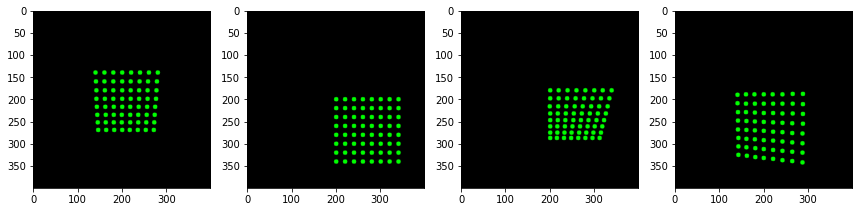

In [34]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# 计算行数
rows = len(params_list) // 5 + (1 if len(params_list) % 5 > 0 else 0)

plt.figure(figsize=(15, 3*rows))  # 调整图像窗口大小
plt.gca().invert_yaxis()  # 反转 y 轴,使其向下增长
for i in range(len(params_list)):
    img = Image.open(os.path.join('out{}.png'.format(i)))
    plt.subplot(rows, 5, i+1)
    plt.imshow(img)
    
plt.tight_layout()  # 调整子图间距
plt.show()

总结一下移动的规律：
* x轴向右，y轴向下, 当 x_axis = y_axis = z_axis = 0 的时候，方阵左上角的点在中间。

In [35]:
data_pairs = []

points2D_raw  = points2D # 没有经过齐次坐标处理
points3D_raw = points3D

print(len(points2D))

# homogeneous coordinates
points2D = np.array(points2D)
points3D = np.array(points3D)
print(len(points2D))

print(points3D.shape)
print(points2D.shape)


256
256
(256, 3)
(256, 2)


In [36]:
import cv2

'''
retval: 标定的重投影误差。越小表示标定效果越好。
cameraMatrix: 相机内部参数矩阵。
distCoeffs: 相机的畸变系数。
rvecs: 旋转向量的列表。
tvecs: 平移向量的列表。
'''


objectPoints = np.float32([points3D_raw])  
imagePoints = np.float32([points2D_raw]) 

objectPoints = objectPoints.reshape(-1,64,3) # 不同视角不同分组！
imagePoints = imagePoints.reshape(-1,64,2)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, (400, 400), None, None)

print(f"重投影误差: {ret: .4e}")
print("-----------------------------------------------------------------------------------------------")
measured_parms = dict()
measured_parms["fx"] = mtx[0][0]
measured_parms["fy"] = mtx[1][1]
measured_parms["cx"] = mtx[0][2]
measured_parms["cy"] = mtx[1][2]

for key in measured_parms.keys():
    print(f"测得的 {key} 值为: {measured_parms[key]}, 实际的 {key} 值为: {camera.dft_configs[key]}, 均方误差为: {np.square(measured_parms[key] - camera.dft_configs[key])}")
print("-----------------------------------------------------------------------------------------------")
print("平均误差: ", np.average([np.square(measured_parms[key] - camera.dft_configs[key]) for key in measured_parms.keys()]))

print(f"焦距: (fx = {measured_parms['fx']}, fy = {measured_parms['fy']})")
print(f"主点坐标: (cx = {measured_parms['cx']}, cy = {measured_parms['cy']})")

重投影误差:  6.6360e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 200.0000492453332, 实际的 fx 值为: 200, 均方误差为: 2.4251028421265106e-09
测得的 fy 值为: 200.0000416349603, 实际的 fy 值为: 200, 均方误差为: 1.7334699189483975e-09
测得的 cx 值为: 199.99997110419005, 实际的 cx 值为: 200, 均方误差为: 8.34967832520376e-10
测得的 cy 值为: 200.00008391574036, 实际的 cy 值为: 200, 均方误差为: 7.041851480471945e-09
-----------------------------------------------------------------------------------------------
平均误差:  3.008848018516807e-09
焦距: (fx = 200.0000492453332, fy = 200.0000416349603)
主点坐标: (cx = 199.99997110419005, cy = 200.00008391574036)


## 开放题1: 总结相机移动的最佳策略

### 策略1: 仅在一个平面上做平移，即保持z坐标不变

选取5个camera position, 保持z_axis = 0

Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64


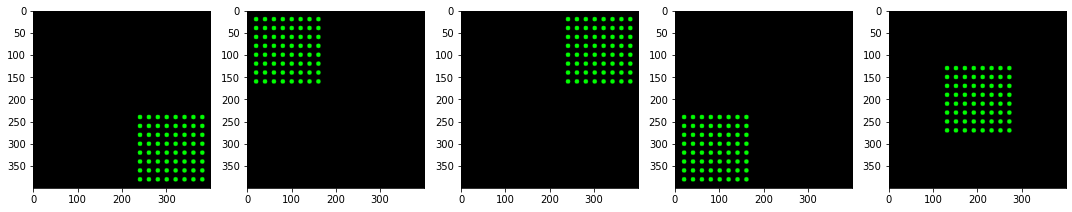

重投影误差:  2.1312e+12
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 1.3099e+19, 实际的 fx 值为: 2.0000e+02, 均方误差为: 1.7159e+38
测得的 fy 值为: 1.3099e+19, 实际的 fy 值为: 2.0000e+02, 均方误差为: 1.7159e+38
测得的 cx 值为: 9.7654e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 6.0302e+05
测得的 cy 值为: -8.2859e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 1.0580e+06
-----------------------------------------------------------------------------------------------
平均误差: 8.5793e+37


(8.57933910291849e+37, 2131182296115.5737)

In [37]:
params_list = [
    {
        "x_axis": 2,
        "y_axis": 2,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 0,
    },
    {
        "x_axis": -9,
        "y_axis": -9,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 0,
    },
        {
        "x_axis": 2,
        "y_axis": -9,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 0,
    },
    {
        "x_axis": -9,
        "y_axis": 2,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 0,
    },
    {
        "x_axis": -3.5,
        "y_axis": -3.5,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 0,
    }       
]


get_result(params_list, True)

### 策略2: 在不同平面上平移，即z轴坐标变化

Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64


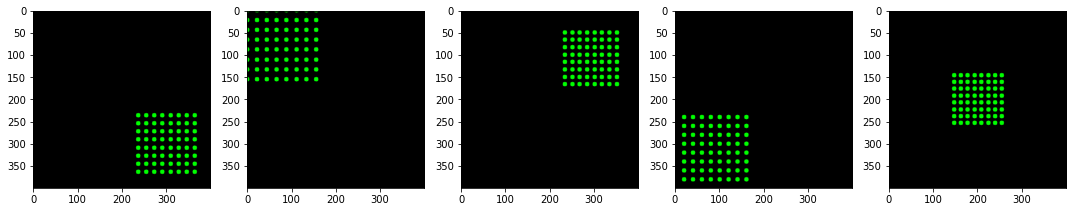

重投影误差:  6.8076e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 5.7709e+05, 实际的 fx 值为: 2.0000e+02, 均方误差为: 3.3280e+11
测得的 fy 值为: 5.7709e+05, 实际的 fy 值为: 2.0000e+02, 均方误差为: 3.3280e+11
测得的 cx 值为: 1.9950e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 2.5009e-01
测得的 cy 值为: 1.9950e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 2.4966e-01
-----------------------------------------------------------------------------------------------
平均误差: 1.6640e+11


(166400362906.83868, 6.807640777216854e-06)

In [38]:
params_list = [
    {
        "x_axis": 2,
        "y_axis": 2,
        "z_axis": 1,
        "yaw": 0,
        "pitch": 0,
    },
    {
        "x_axis": -9,
        "y_axis": -9,
        "z_axis": -1,
        "yaw": 0,
        "pitch": 0,
    },
        {
        "x_axis": 2,
        "y_axis": -9,
        "z_axis": 2,
        "yaw": 0,
        "pitch": 0,
    },
    {
        "x_axis": -9,
        "y_axis": 2,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 0,
    },
    {
        "x_axis": -3.5,
        "y_axis": -3.5,
        "z_axis": 3,
        "yaw": 0,
        "pitch": 0,
    }       
]


get_result(params_list, True)

### 策略3: 保持z_axis不变，旋转相机

我们在这里只选择yaw角和pitch角；roll是绕着z轴旋转，一直都是和图像平面平行。

Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64


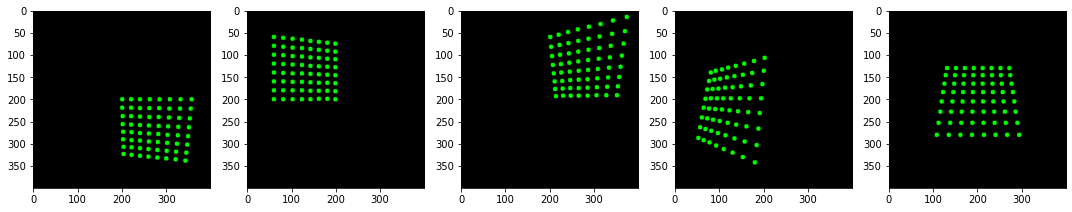

重投影误差:  7.5122e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 3.6251e-10
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 2.5943e-10
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 8.7828e-11
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 1.1010e-10
-----------------------------------------------------------------------------------------------
平均误差: 2.0496e-10


(2.0496494356478364e-10, 7.5121875530394005e-06)

In [39]:
params_list = [
    {
        "x_axis": 0,
        "y_axis": 0,
        "z_axis": 0,
        "yaw": 10,
        "pitch": 10,
    },
    {
        "x_axis": -7,
        "y_axis": -7,
        "z_axis": 0,
        "yaw": -10,
        "pitch": 0,
    },
        {
        "x_axis": 0,
        "y_axis": -7,
        "z_axis": 0,
        "yaw": 20,
        "pitch": 20,
    },
    {
        "x_axis": -6,
        "y_axis": -3,
        "z_axis": 0,
        "yaw": 30,
        "pitch": -10,
    },
    {
        "x_axis": -3.5,
        "y_axis": -3.5,
        "z_axis": 0,
        "yaw": 0,
        "pitch": -20,
    }       
]

get_result(params_list, True)

### 策略4: z_axis改变，同时旋转相机

Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64


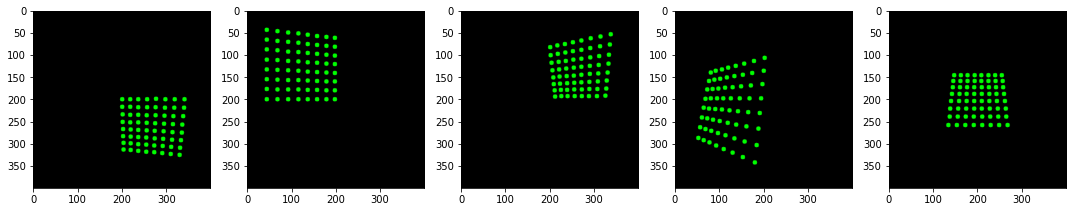

重投影误差:  6.9539e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 1.7654e-09
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 1.6127e-09
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 1.4738e-11
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 2.5114e-10
-----------------------------------------------------------------------------------------------
平均误差: 9.1098e-10


(9.109801540677284e-10, 6.953860632474222e-06)

In [40]:
params_list = [
    {
        "x_axis": 0,
        "y_axis": 0,
        "z_axis": 1,
        "yaw": 10,
        "pitch": 10,
    },
    {
        "x_axis": -7,
        "y_axis": -7,
        "z_axis": -1,
        "yaw": -10,
        "pitch": 0,
    },
        {
        "x_axis": 0,
        "y_axis": -7,
        "z_axis": 2,
        "yaw": 20,
        "pitch": 20,
    },
    {
        "x_axis": -6,
        "y_axis": -3,
        "z_axis": 0,
        "yaw": 30,
        "pitch": -10,
    },
    {
        "x_axis": -3.5,
        "y_axis": -3.5,
        "z_axis": 3,
        "yaw": 0,
        "pitch": -20,
    }       
]

get_result(params_list, True)

## 结果总结

* 策略1: 仅在一个平面上做平移, 比如让z坐标不变
* 策略2: 在不同平面上平移，比如令z轴坐标变化
* 策略3: 保持z_axis不变，旋转相机
* 策略4: z_axis改变，同时旋转相机


|    | 策略1        | 策略2        | 策略3      | 策略4  |
|------------|----------|----------|---------| ---------|
| 重投影误差        | 2.1312e+12  | 6.8076e-06  | 7.5122e-06 | 6.9539e-06 |
| 均方误差均值      | 8.5793e+37 | 1.6640e+11 | 2.0496e-10 | 9.1098e-10 |


* 从表中可以看出，就相机移动而言，在一个平面上做平移是显然不妥的，要尽量让得到的二维图片中的点不在一个平面上。
* 而如果仅仅改变z轴坐标，那么得到的图片虽然不在一个平面上，但是仍然是平行的；虽然测得的重投影误差小，但是参数误差较大。**可见仅仅用重投影误差衡量相机参数标定的误差是不可靠的**。
* 改变相机的旋转角能很好地提高标定的准确度；同时改变z_axis并不一定能带来更好的标定效果，这可能需要进一步的探究




## 测试yaw角旋转和pitch角旋转在相机标定中是否有某种对称关系（简单探究）

一个问题：如果如果旋转角就图像而言对称，那测定结果是否会相同呢？


### 旋转yaw角

Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64


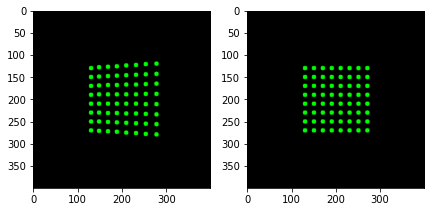

重投影误差:  3.8281e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 202.9438958918785, 实际的 fx 值为: 200, 均方误差为: 8.666523022219096
测得的 fy 值为: 202.94389588490793, 实际的 fy 值为: 200, 均方误差为: 8.666522981177852
测得的 cx 值为: 199.4770630234763, 实际的 cx 值为: 200, 均方误差为: 0.2734630814157587
测得的 cy 值为: 200.00001454404222, 实际的 cy 值为: 200, 均方误差为: 2.1152916397795887e-10
-----------------------------------------------------------------------------------------------
平均误差:  4.401627271256059


In [41]:
params_list = [
    {
        "x_axis": -3.5,
        "y_axis": -3.5,
        "z_axis": 0,
        "yaw": 10,
        "pitch": 0,
    },
    {
        "x_axis": -3.5,
        "y_axis": -3.5,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 0,
    }       
]

# 得到二维投影点

camera = CameraModel()
chessboard = chessboard3D()
points3D = chessboard.return_points()
points2D = []
first = True


for i in range(len(params_list)):
    parms = params_list[i]
    camera.move_x_axis_plus(parms["x_axis"])
    camera.move_y_axis_plus(parms["y_axis"])
    camera.move_z_axis_plus(parms["z_axis"])
    camera.rotate_yaw_plus(parms["yaw"])
    camera.rotate_pitch_plus(parms["pitch"])
    if first:
        points2D = camera.project(points3D).tolist()
        camera.draw(np.array(points2D), "out{}.png".format(i))
        first = False
    else:
        new = camera.project(points3D).tolist()
        camera.draw(np.array(new), "out{}.png".format(i))
        points2D = points2D + camera.project(points3D).tolist()
    camera.reset()
    


points3D = points3D.tolist() * len(params_list)

# 计算行数
rows = len(params_list) // 5 + (1 if len(params_list) % 5 > 0 else 0)

plt.figure(figsize=(15, 3*rows)) 
plt.gca().invert_yaxis()  
for i in range(len(params_list)):
    img = Image.open(os.path.join('out{}.png'.format(i)))
    plt.subplot(rows, 5, i+1)
    plt.imshow(img)
    
plt.tight_layout()  
plt.show()

objectPoints = np.float32([points3D])  
imagePoints = np.float32([points2D]) 

objectPoints = objectPoints.reshape(-1,64,3) # 不同视角不同分组！
imagePoints = imagePoints.reshape(-1,64,2)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, (400, 400), None, None)

print(f"重投影误差: {ret: .4e}")
print("-----------------------------------------------------------------------------------------------")
measured_parms = dict()
measured_parms["fx"] = mtx[0][0]
measured_parms["fy"] = mtx[1][1]
measured_parms["cx"] = mtx[0][2]
measured_parms["cy"] = mtx[1][2]

for key in measured_parms.keys():
    print(f"测得的 {key} 值为: {measured_parms[key]}, 实际的 {key} 值为: {camera.dft_configs[key]}, 均方误差为: {np.square(measured_parms[key] - camera.dft_configs[key])}")
print("-----------------------------------------------------------------------------------------------")
print("平均误差: ", np.average([np.square(measured_parms[key] - camera.dft_configs[key]) for key in measured_parms.keys()]))

### pitch角

Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64


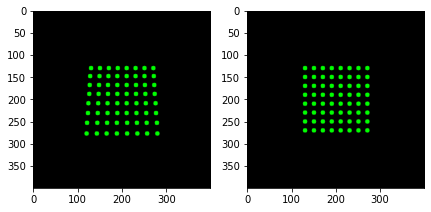

重投影误差:  3.8281e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 202.94380082595347, 实际的 fx 值为: 200, 均方误差为: 8.665963302884355
测得的 fy 值为: 202.94380083292236, 实际的 fy 值为: 200, 均方误差为: 8.6659633439144
测得的 cx 值为: 200.0000145440259, 实际的 cx 值为: 200, 均方误差为: 2.1152868943343502e-10
测得的 cy 值为: 199.47708003945988, 实际的 cy 值为: 200, 均方误差为: 0.27344528513128274
-----------------------------------------------------------------------------------------------
平均误差:  4.401342983035391


In [42]:
params_list = [
    {
        "x_axis": -3.5,
        "y_axis": -3.5,
        "z_axis": 0,
        "yaw": 0,
        "pitch": -10,
    },
    {
        "x_axis": -3.5,
        "y_axis": -3.5,
        "z_axis": 0,
        "yaw": 0,
        "pitch": 0,
    }       
]

# 得到二维投影点

camera = CameraModel()
chessboard = chessboard3D()
points3D = chessboard.return_points()
points2D = []
first = True


for i in range(len(params_list)):
    parms = params_list[i]
    camera.move_x_axis_plus(parms["x_axis"])
    camera.move_y_axis_plus(parms["y_axis"])
    camera.move_z_axis_plus(parms["z_axis"])
    camera.rotate_yaw_plus(parms["yaw"])
    camera.rotate_pitch_plus(parms["pitch"])
    if first:
        points2D = camera.project(points3D).tolist()
        camera.draw(np.array(points2D), "out{}.png".format(i))
        first = False
    else:
        new = camera.project(points3D).tolist()
        camera.draw(np.array(new), "out{}.png".format(i))
        points2D = points2D + camera.project(points3D).tolist()
    camera.reset()
    


points3D = points3D.tolist() * len(params_list)

# 计算行数
rows = len(params_list) // 5 + (1 if len(params_list) % 5 > 0 else 0)

plt.figure(figsize=(15, 3*rows)) 
plt.gca().invert_yaxis()  
for i in range(len(params_list)):
    img = Image.open(os.path.join('out{}.png'.format(i)))
    plt.subplot(rows, 5, i+1)
    plt.imshow(img)
    
plt.tight_layout()  
plt.show()

objectPoints = np.float32([points3D])  
imagePoints = np.float32([points2D]) 

objectPoints = objectPoints.reshape(-1,64,3) # 不同视角不同分组！
imagePoints = imagePoints.reshape(-1,64,2)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, (400, 400), None, None)

print(f"重投影误差: {ret: .4e}")
print("-----------------------------------------------------------------------------------------------")
measured_parms = dict()
measured_parms["fx"] = mtx[0][0]
measured_parms["fy"] = mtx[1][1]
measured_parms["cx"] = mtx[0][2]
measured_parms["cy"] = mtx[1][2]

for key in measured_parms.keys():
    print(f"测得的 {key} 值为: {measured_parms[key]}, 实际的 {key} 值为: {camera.dft_configs[key]}, 均方误差为: {np.square(measured_parms[key] - camera.dft_configs[key])}")
print("-----------------------------------------------------------------------------------------------")
print("平均误差: ", np.average([np.square(measured_parms[key] - camera.dft_configs[key]) for key in measured_parms.keys()]))

从图中可以看出，当改变的 yaw = -pitch的时候（其他参数不变），标定的结果十分接近。

## 开放题2: 探究二维投影点集合数量对标定结果的影响


In [43]:
import numpy as np

def generate_parm_list(set_num):
    """
    生成set_num个参数列表

    Args:
        set_num (int): 生成的参数列表的数量
    """
    params_list = []
    for i in range(set_num):
        # 尽量减少invalid point，所以随机范围不能太大
        param_grp = {
            "x_axis": np.random.uniform(-4, -3),
            "y_axis": np.random.uniform(-4, -3),
            "z_axis": np.random.uniform(-1, 1),
            "yaw": 25 * np.random.uniform(-1, 1),
            "pitch": 25 * np.random.uniform(-1, 1),
        }
        params_list.append(param_grp)
    return params_list

Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64


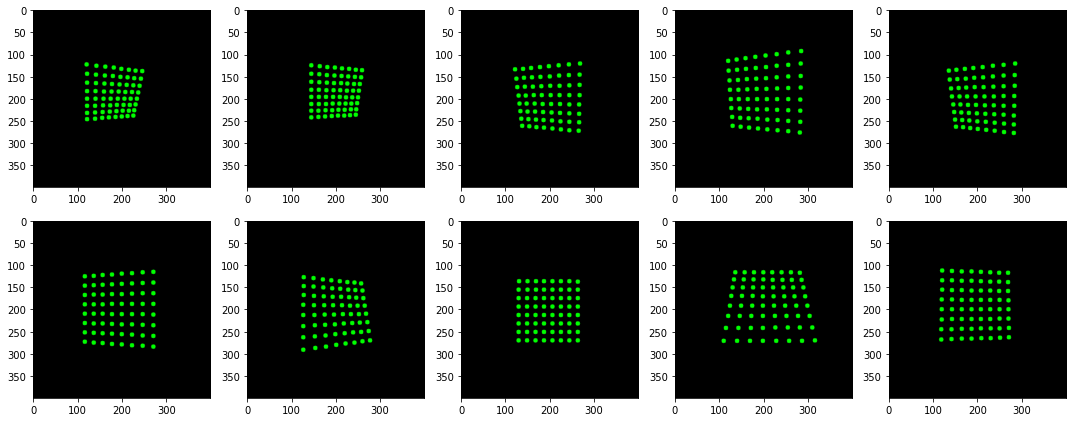

重投影误差:  6.8529e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 5.4340e-10
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 5.5199e-10
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 5.2460e-11
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 3.4635e-11
-----------------------------------------------------------------------------------------------
平均误差: 2.9562e-10
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64

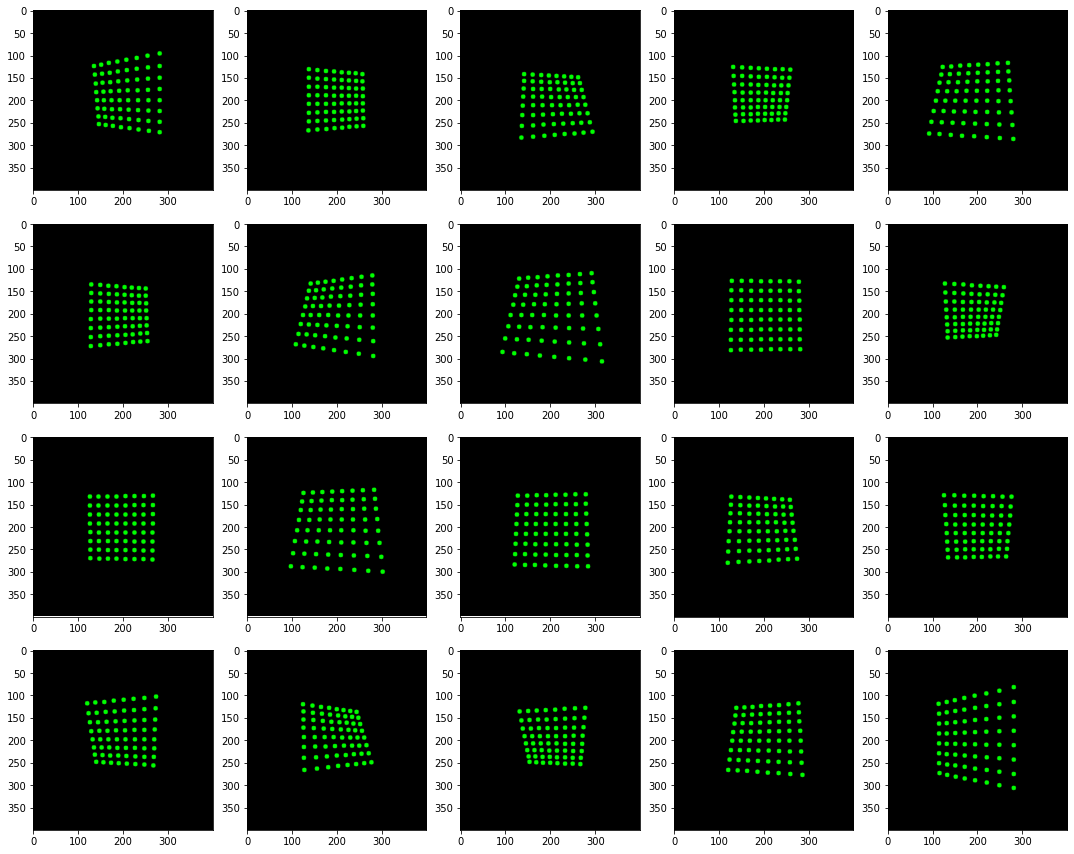

重投影误差:  7.0306e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 7.2392e-12
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 5.4258e-12
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 3.2769e-12
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 1.6370e-11
-----------------------------------------------------------------------------------------------
平均误差: 8.0779e-12
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64

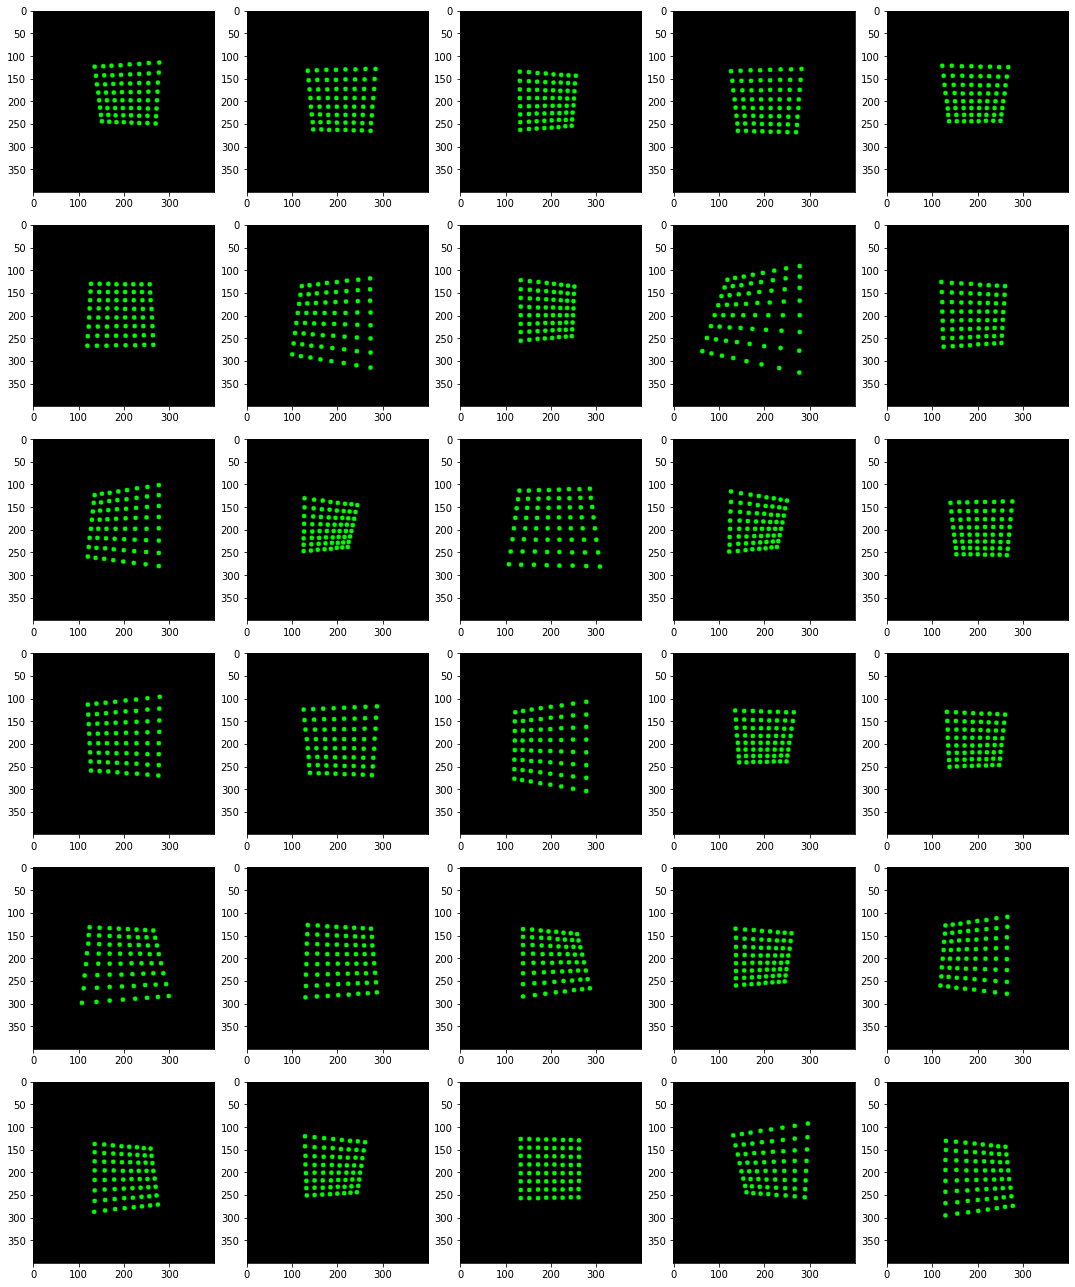

重投影误差:  6.8141e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 9.8978e-11
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 1.0357e-10
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 6.7009e-11
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 1.2087e-10
-----------------------------------------------------------------------------------------------
平均误差: 9.7607e-11
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64

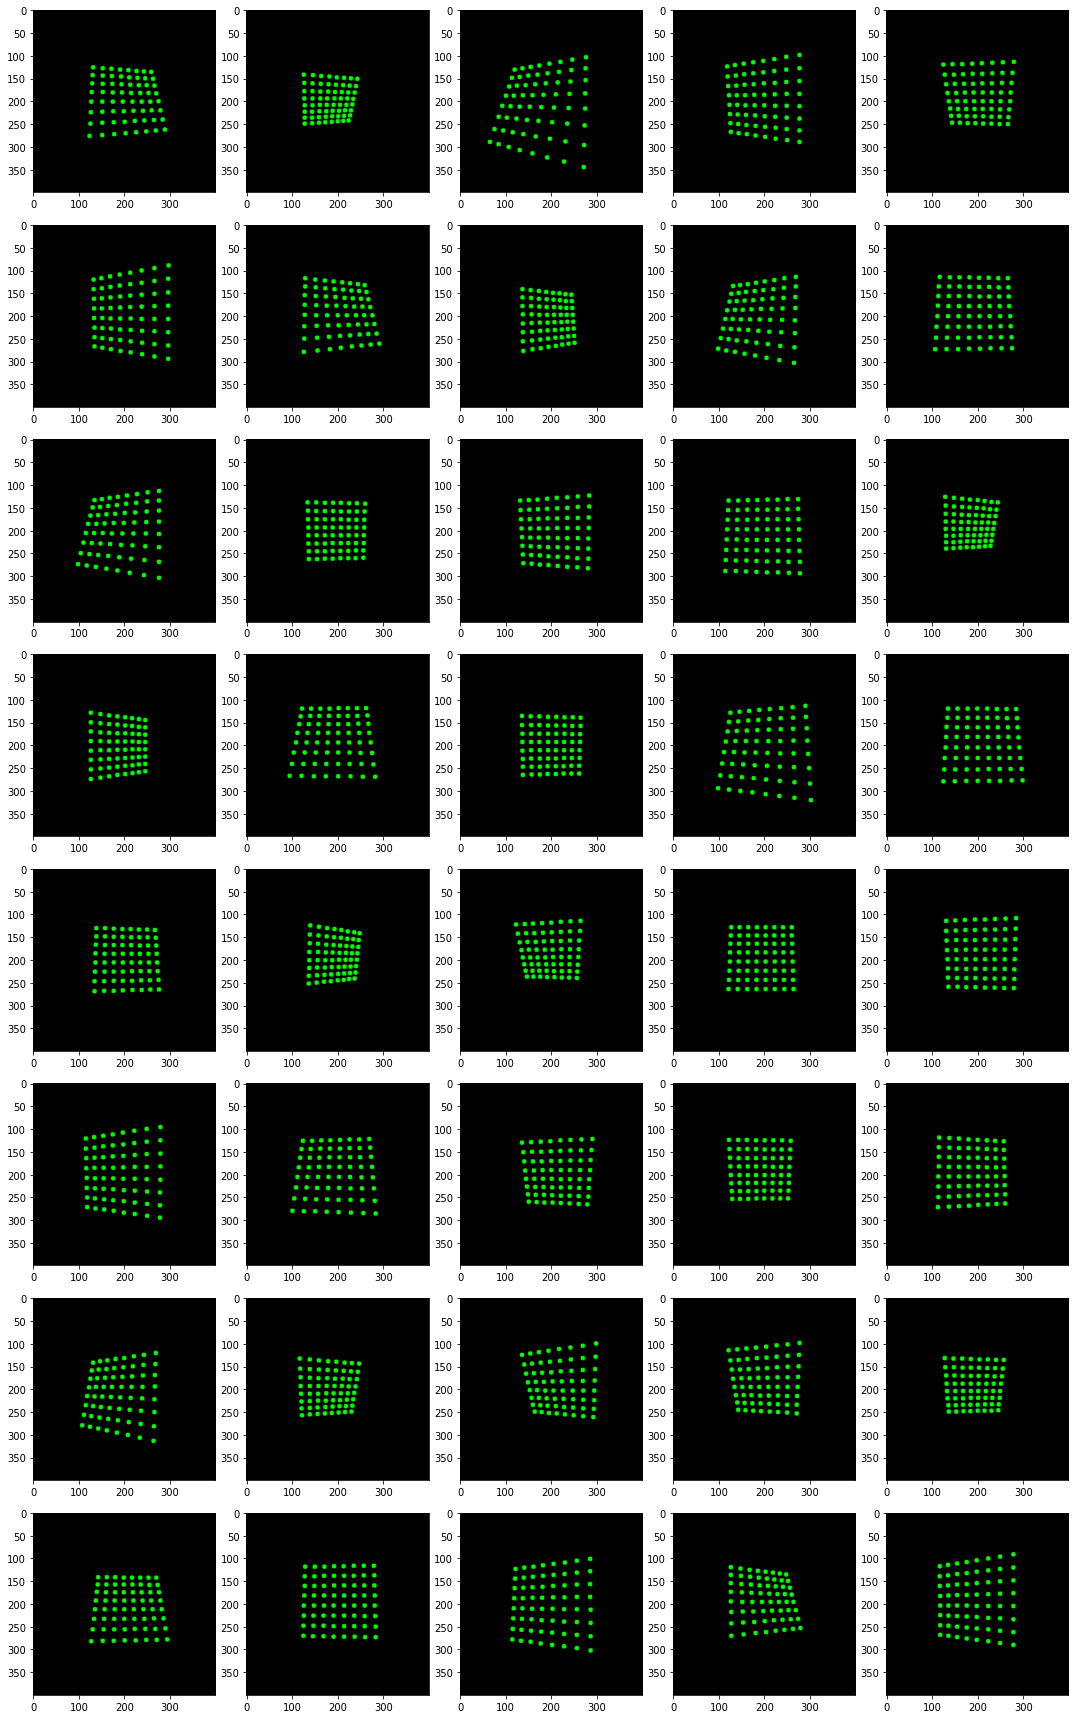

重投影误差:  7.0251e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 2.6143e-11
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 1.9404e-11
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 8.0585e-11
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 2.4069e-14
-----------------------------------------------------------------------------------------------
平均误差: 3.1539e-11
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64

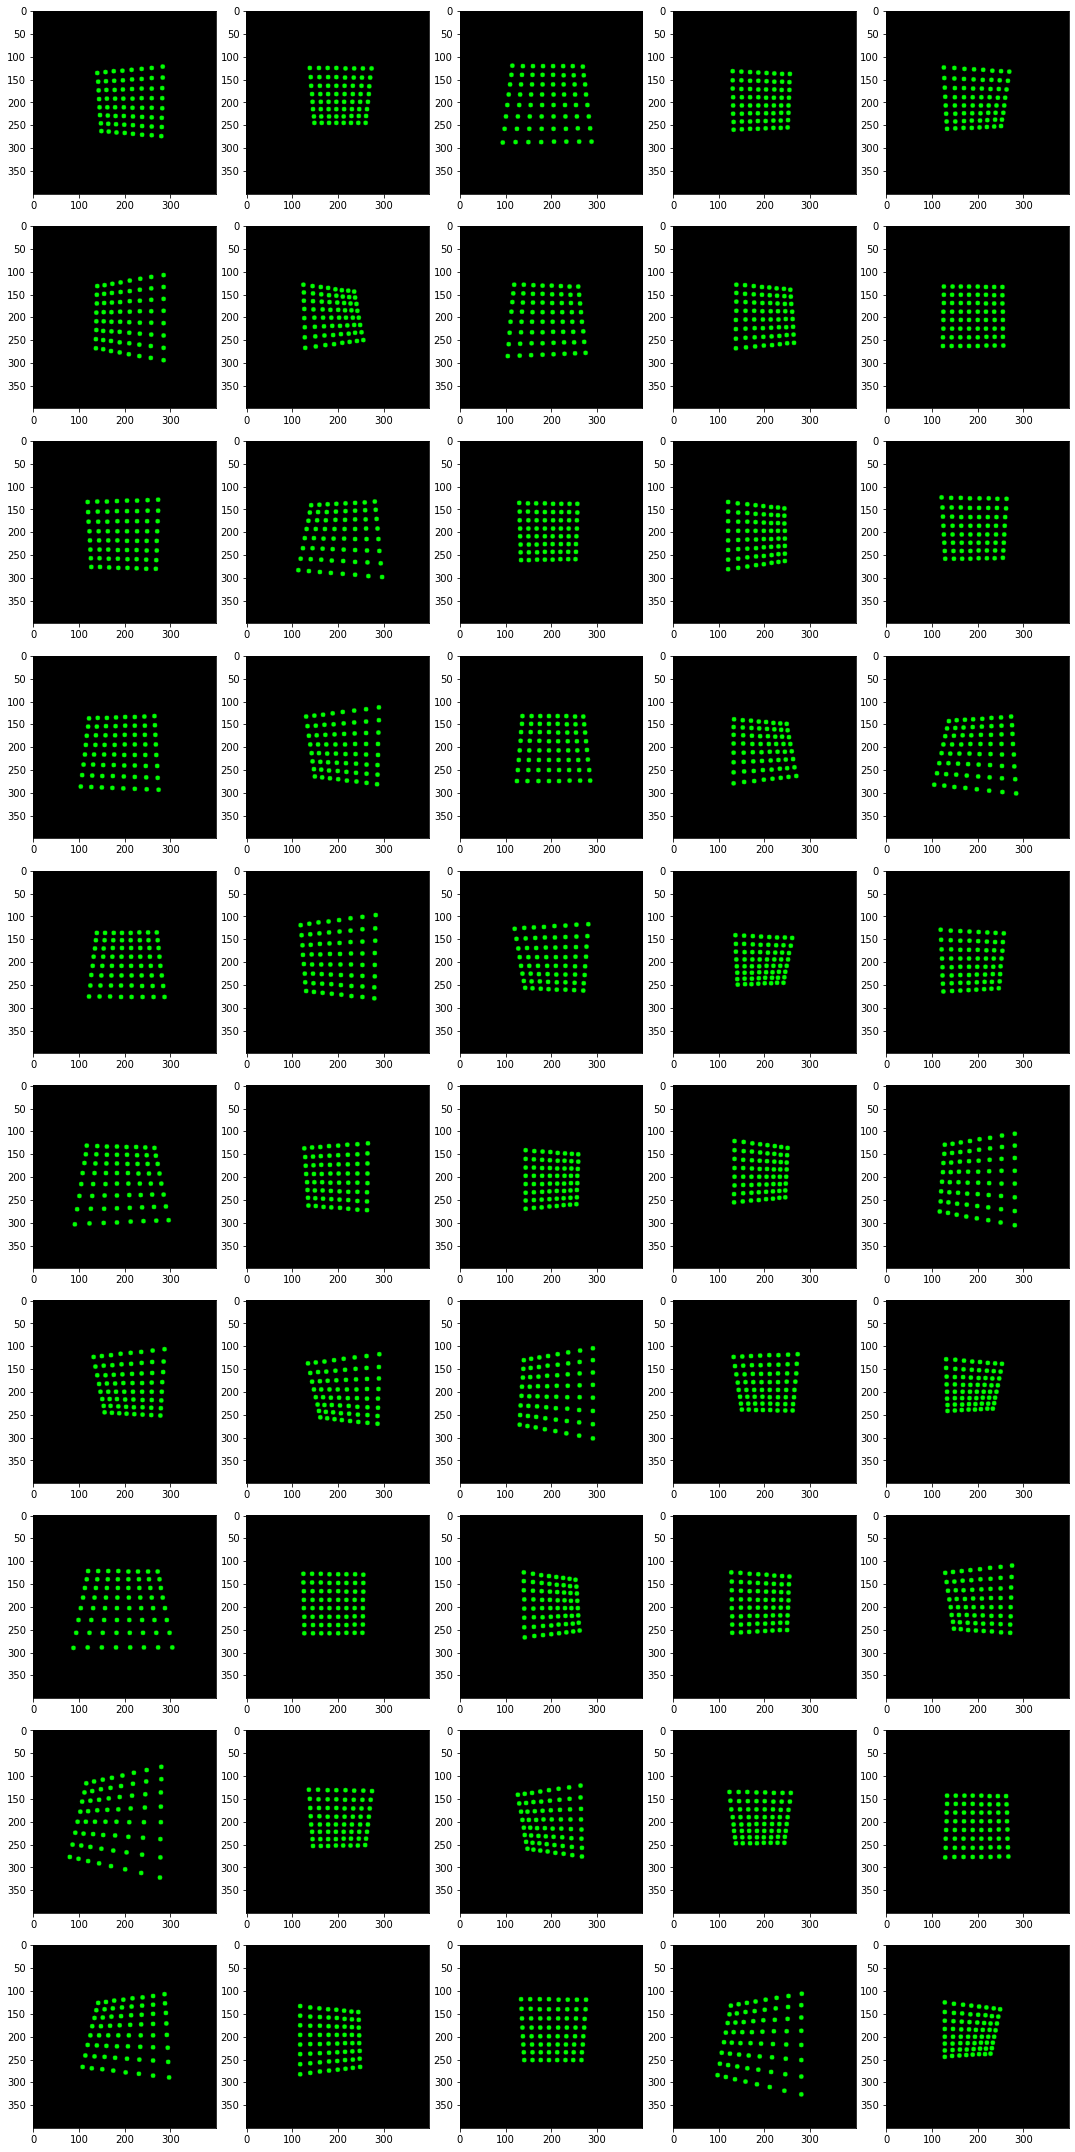

重投影误差:  6.9522e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 2.0898e-11
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 2.1391e-11
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 3.0915e-11
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 1.3137e-12
-----------------------------------------------------------------------------------------------
平均误差: 1.8629e-11
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64

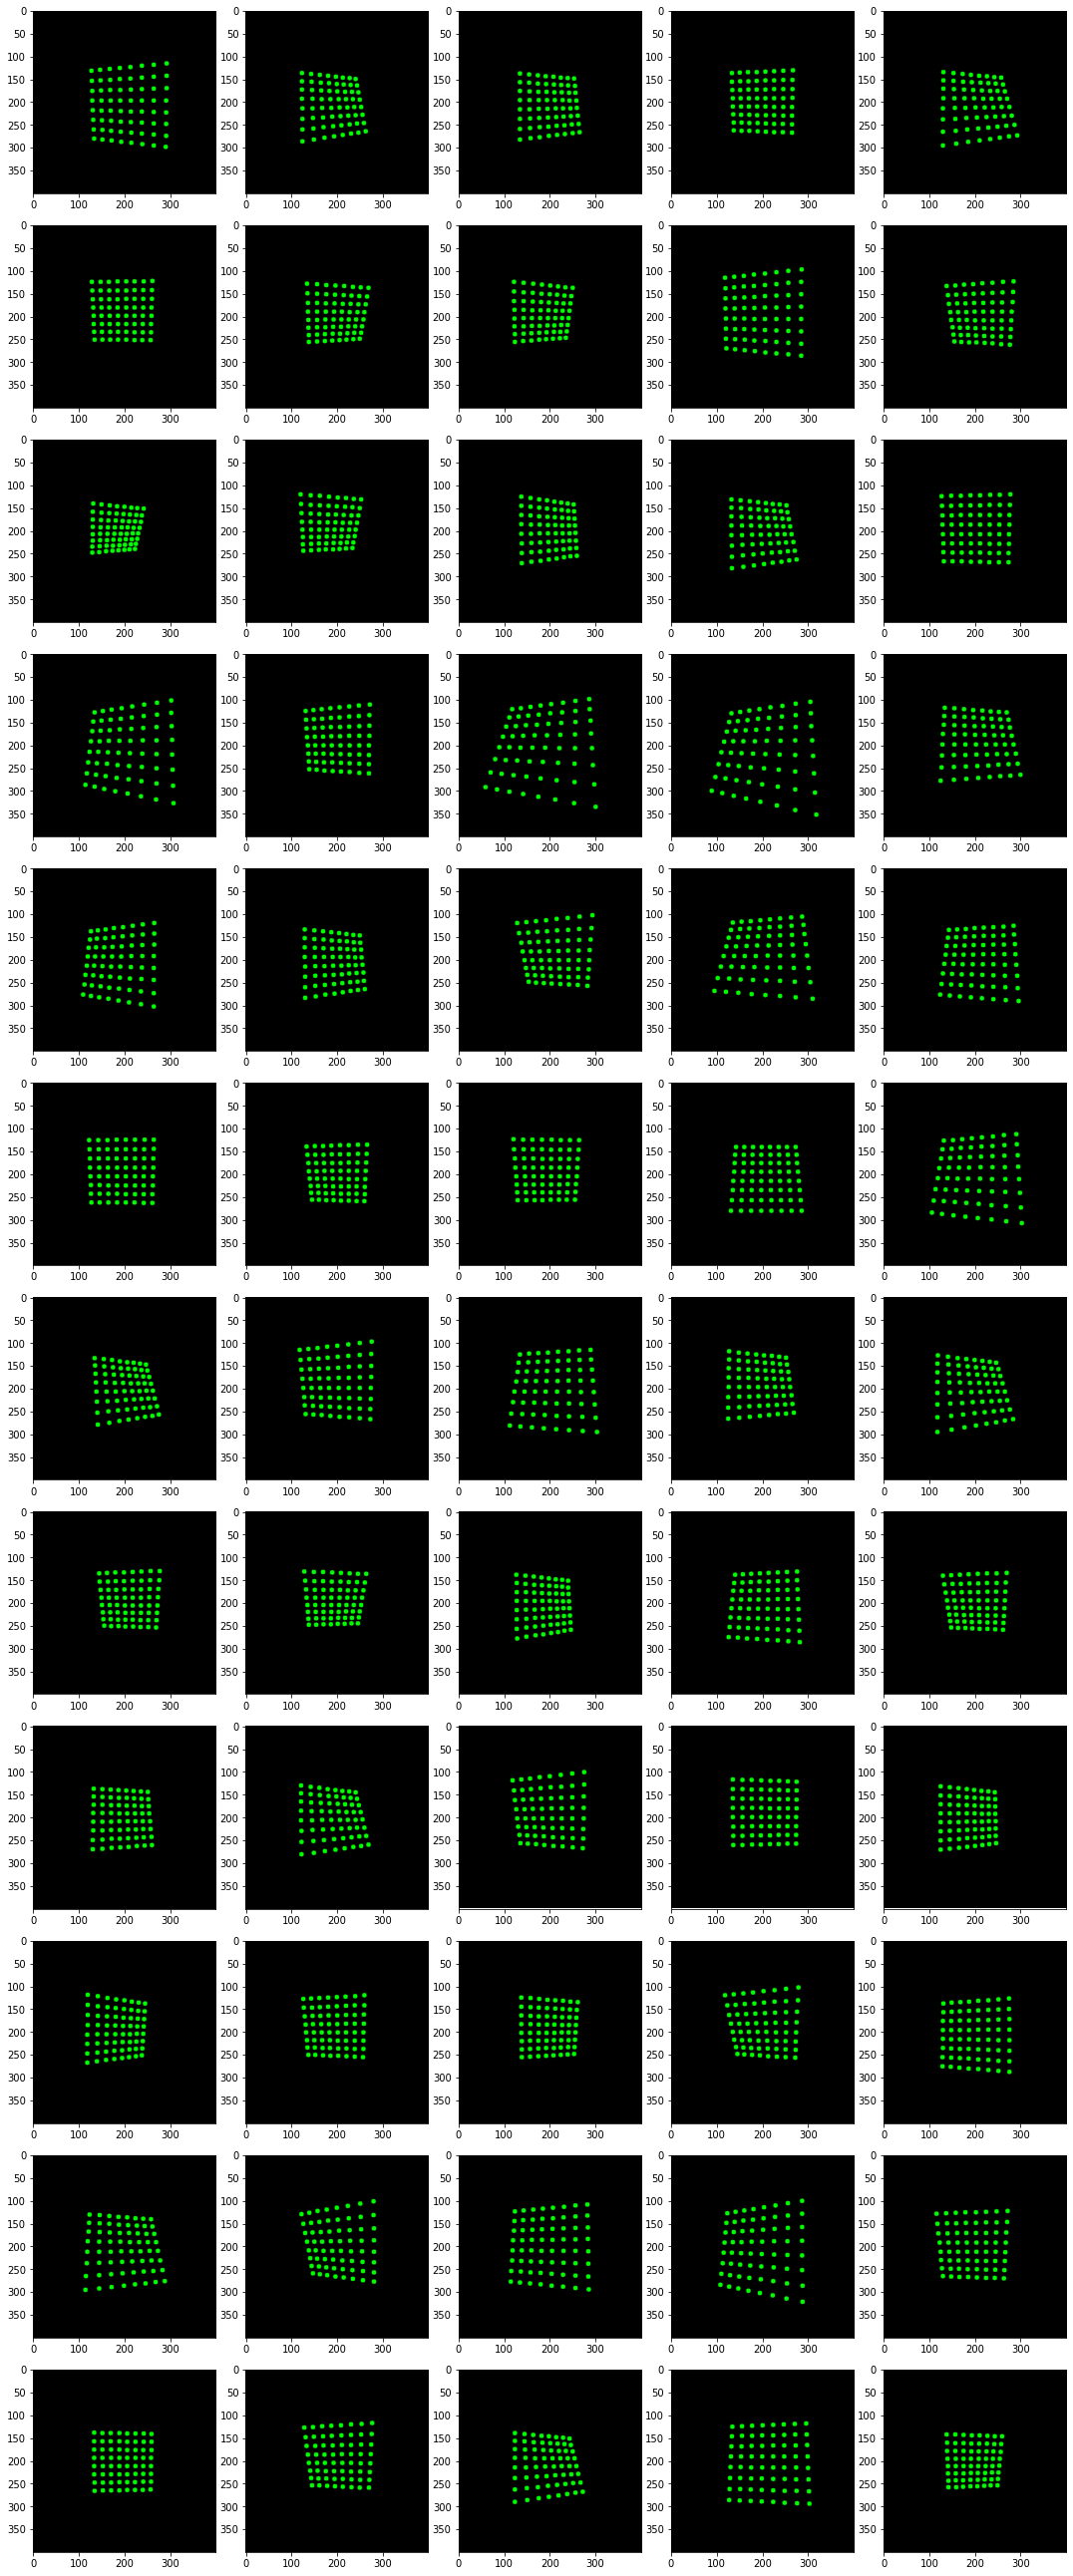

重投影误差:  7.0094e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 6.3837e-11
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 5.9913e-11
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 5.4346e-11
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 1.8970e-11
-----------------------------------------------------------------------------------------------
平均误差: 4.9267e-11
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64

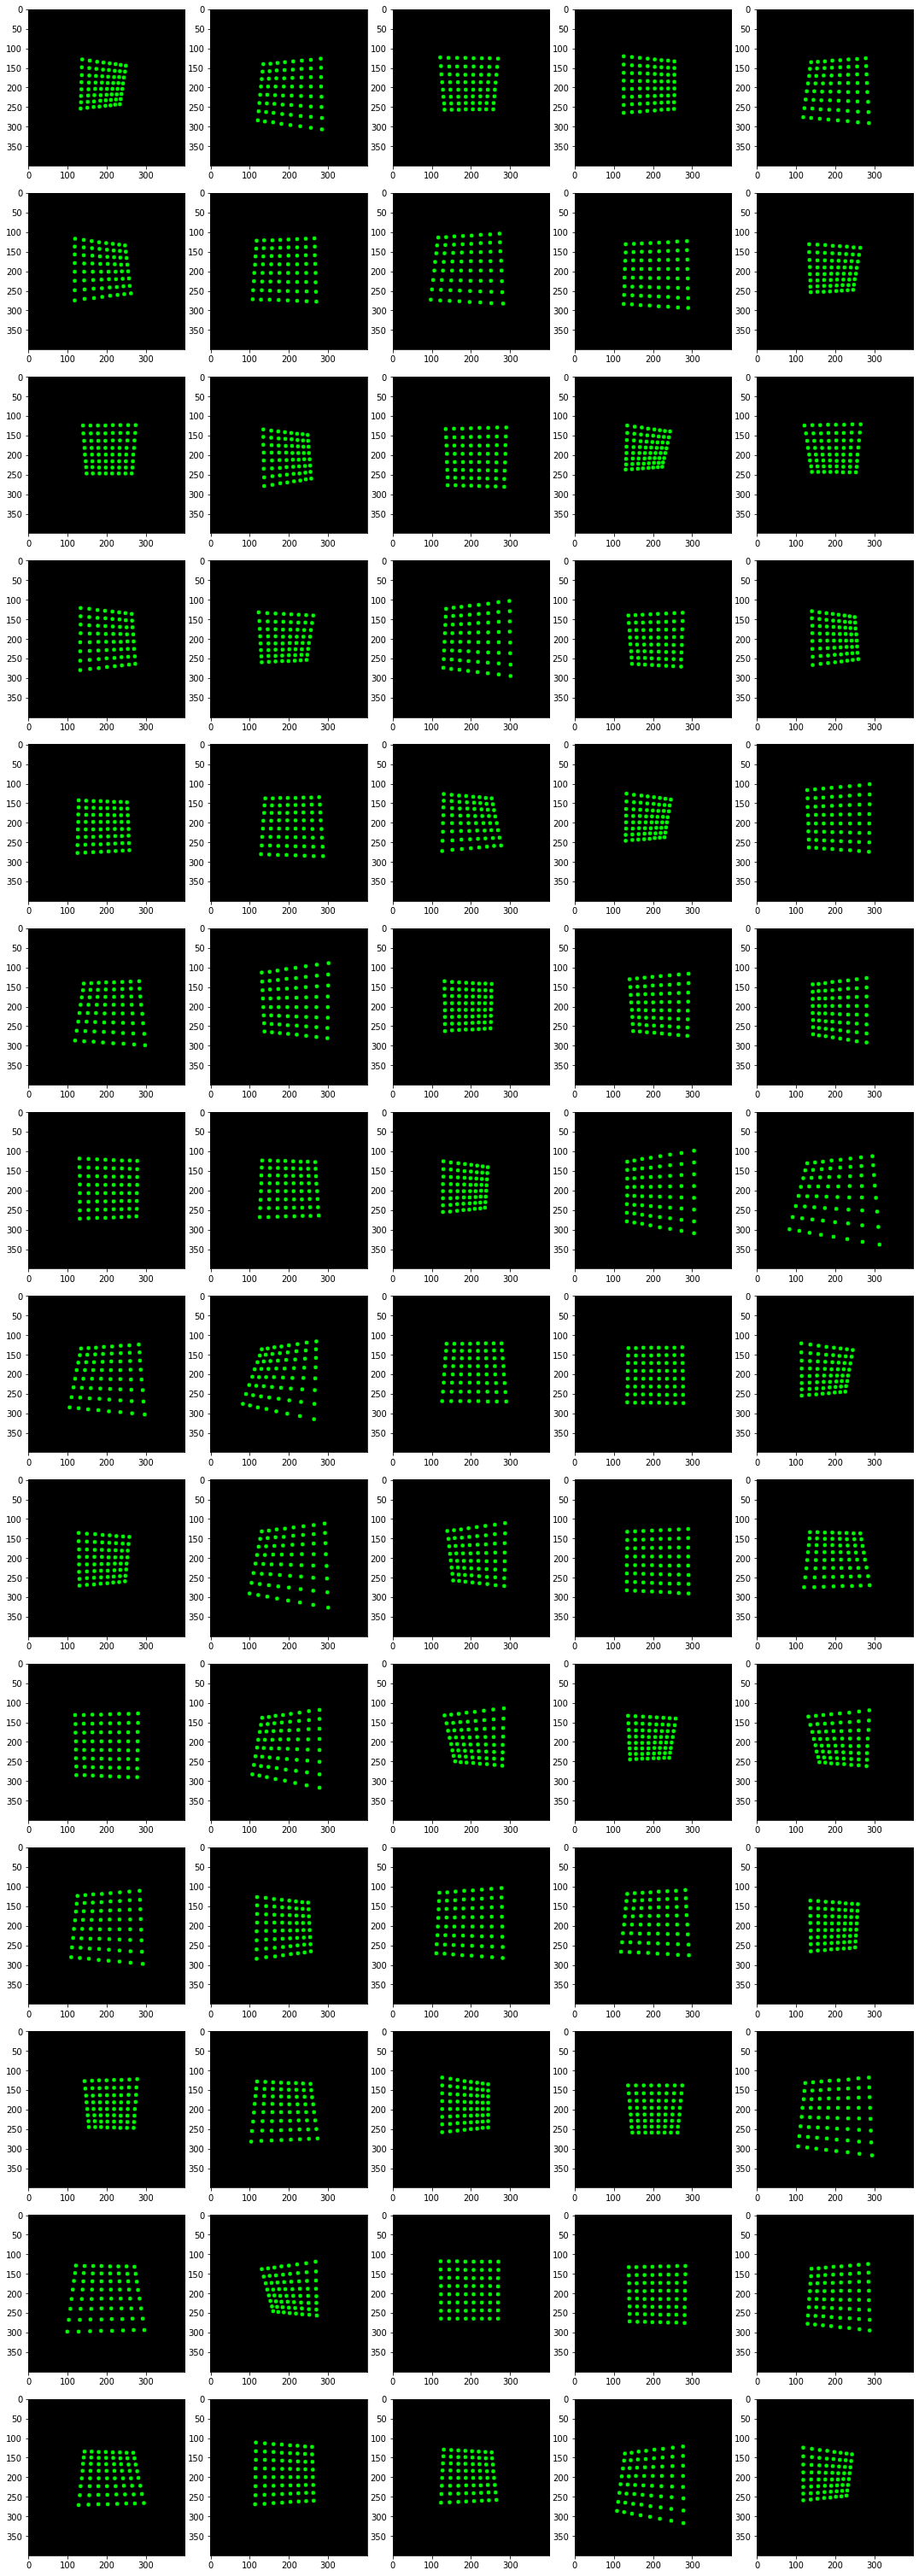

重投影误差:  7.1648e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 5.6874e-14
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 6.5918e-13
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 2.1775e-12
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 5.3921e-11
-----------------------------------------------------------------------------------------------
平均误差: 1.4204e-11
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64

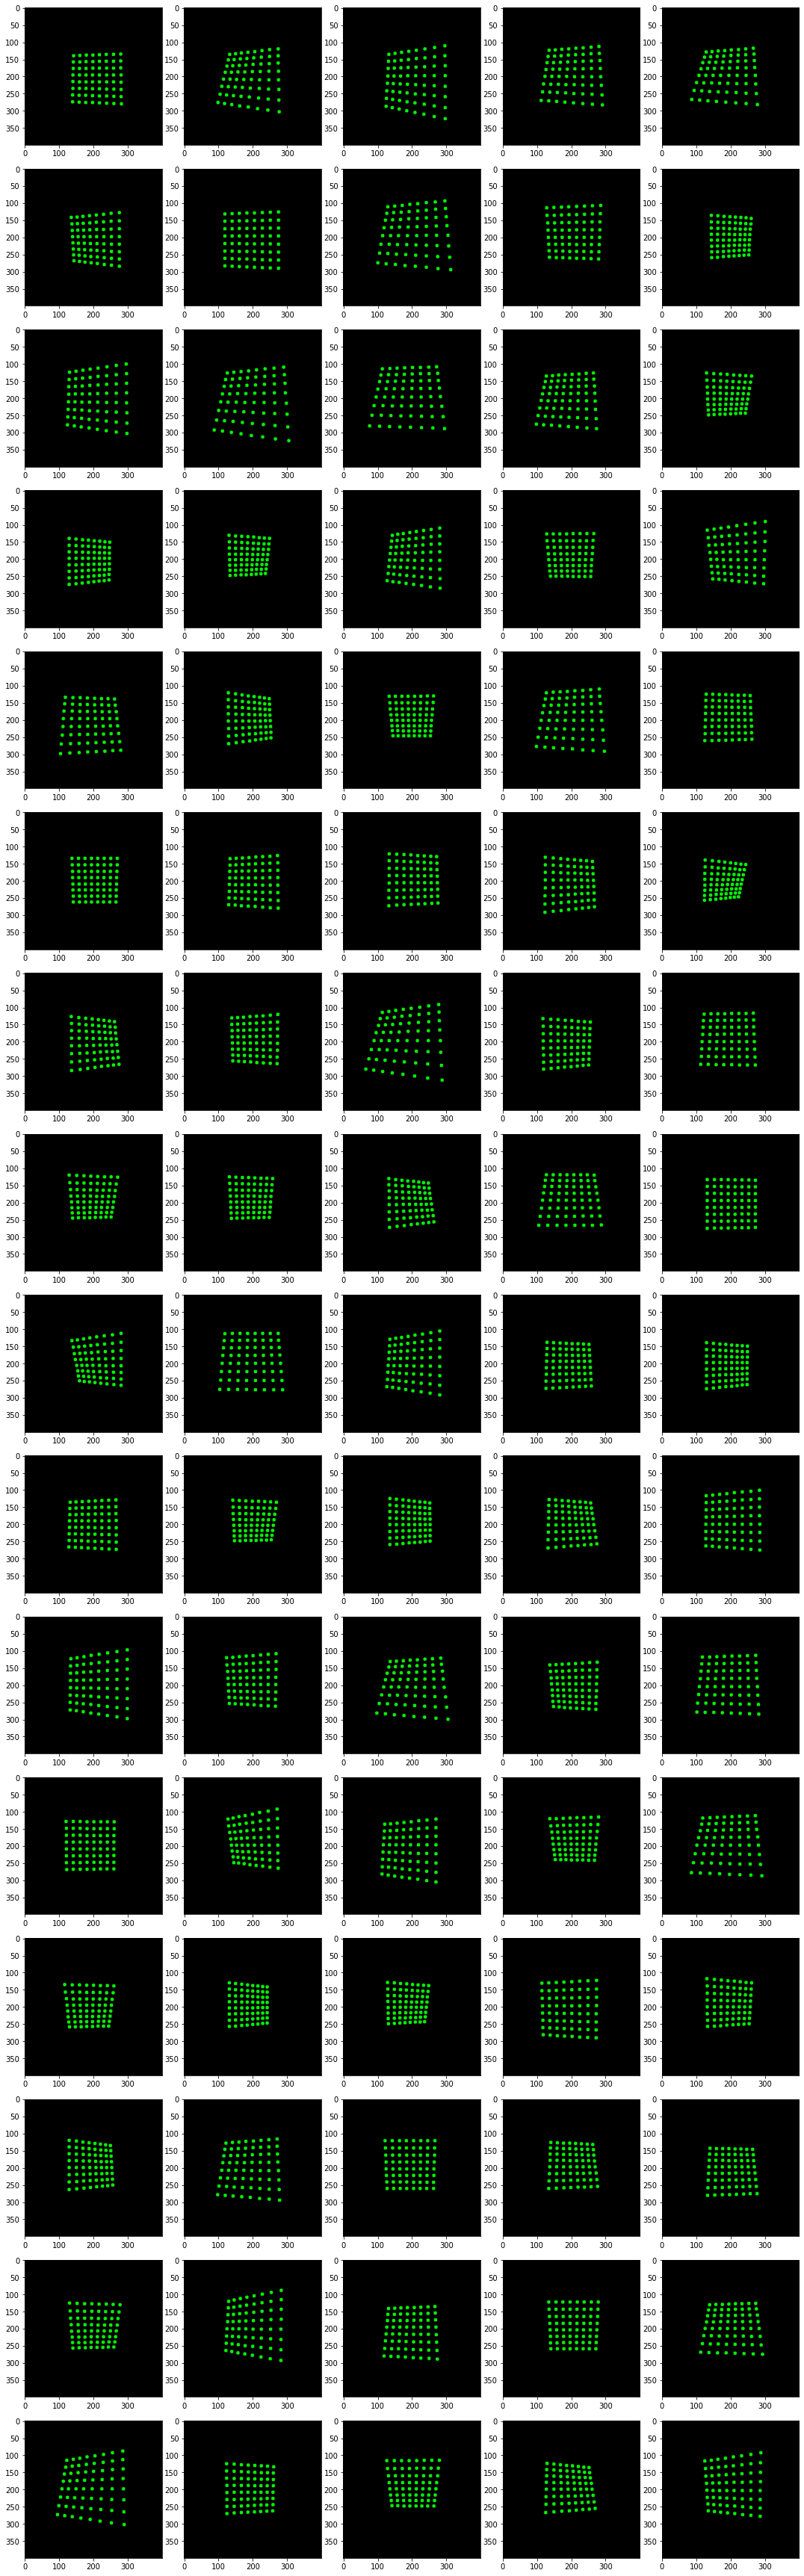

重投影误差:  7.0297e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 4.8436e-12
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 4.0425e-12
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 3.0376e-12
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 1.0783e-11
-----------------------------------------------------------------------------------------------
平均误差: 5.6766e-12
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64
Outside image count: 0, while total points: 64

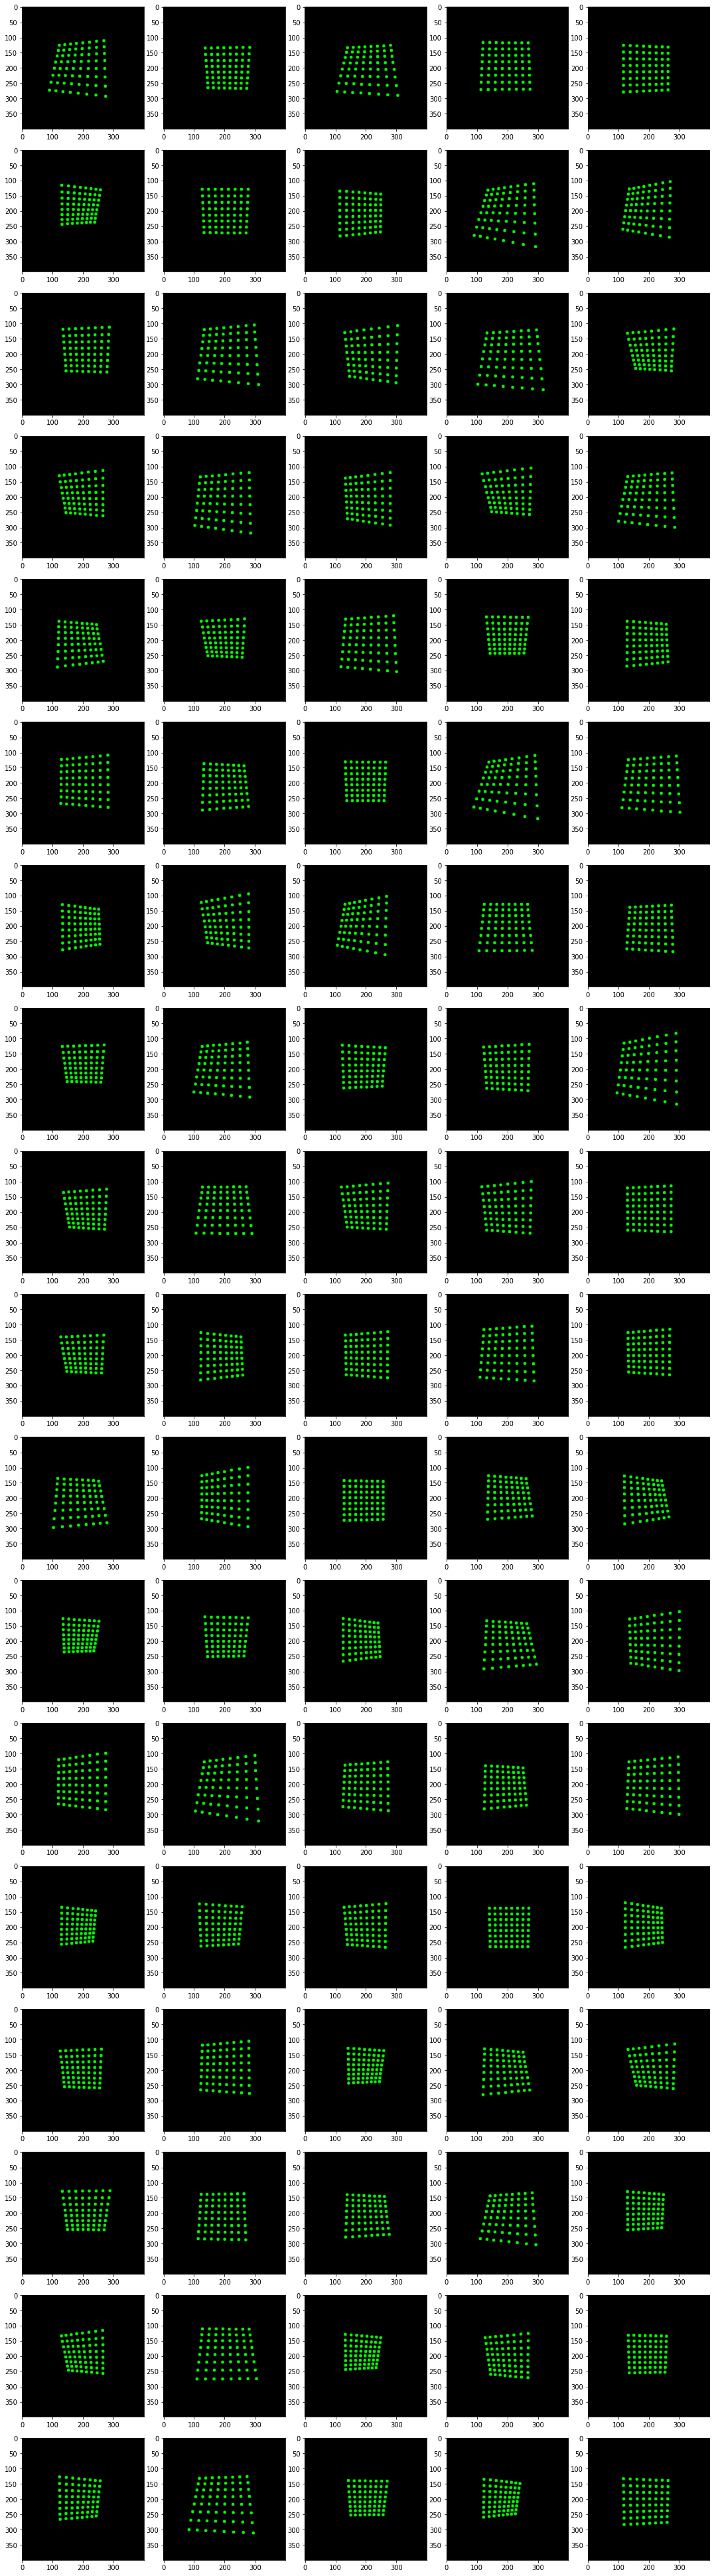

重投影误差:  7.1029e-06
-----------------------------------------------------------------------------------------------
测得的 fx 值为: 2.0000e+02, 实际的 fx 值为: 2.0000e+02, 均方误差为: 1.0047e-11
测得的 fy 值为: 2.0000e+02, 实际的 fy 值为: 2.0000e+02, 均方误差为: 8.7349e-12
测得的 cx 值为: 2.0000e+02, 实际的 cx 值为: 2.0000e+02, 均方误差为: 2.9703e-11
测得的 cy 值为: 2.0000e+02, 实际的 cy 值为: 2.0000e+02, 均方误差为: 2.1898e-14
-----------------------------------------------------------------------------------------------
平均误差: 1.2127e-11


In [44]:
num_list = np.arange(10, 100, 10)
mse_list = []
ret_list = []

for num in num_list:
    params_list = generate_parm_list(num)
    mse, ret = get_result(params_list, verbose=True)
    mse_list.append(mse)
    ret_list.append(ret)



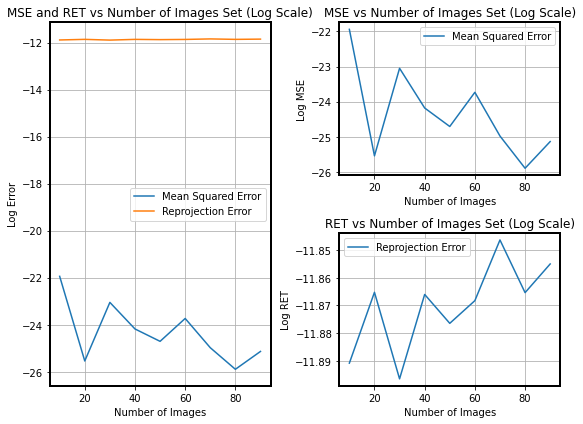

In [45]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))  


plt.subplot(1, 3, 1)
plt.plot(num_list, np.log(mse_list), label='Mean Squared Error')
plt.plot(num_list, np.log(ret_list), label='Reprojection Error')
plt.title('MSE and RET vs Number of Images Set (Log Scale)')
plt.xlabel('Number of Images')
plt.ylabel('Log Error')
plt.legend()
plt.grid()


plt.subplot(2, 3, 2)
plt.plot(num_list, np.log(mse_list), label='Mean Squared Error')
plt.title('MSE vs Number of Images Set (Log Scale)')
plt.xlabel('Number of Images')
plt.ylabel('Log MSE')
plt.legend()
plt.grid()


plt.subplot(2, 3, 5)
plt.plot(num_list, np.log(ret_list), label='Reprojection Error')
plt.title('RET vs Number of Images Set (Log Scale)')
plt.xlabel('Number of Images')
plt.ylabel('Log RET')
plt.legend()
plt.grid()


plt.tight_layout()

for ax in plt.gcf().axes:
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

plt.show()

从图中可以看出，标定误差并非随着所用二维投影点集合数量的增多而持续上升，即并非二维投影点集合数量越多越好。可见标定质量和所选的二维投影点集合之间的关系有关，结合第一个实验中的观察，让这些二维投影点集尽量不在一个平面上、彼此间不平行是标定结果更重要的影响因素。

## 尝试实现DLT算法，但是失败了；记录了一下过程

In [ ]:


# Normalization. Use a similarity transformation T to normalize the image points, and asecond similarity transformation U to normalize the space ponits

def normalize_2Dpoints(points):
    '''
    points: 'numpy.ndarray', shape = (n, 2) or (n, 3) for homogeneous coordinates
    Returns similarity transformation T, and normalized points.
    '''
    if points.shape[1] == 3:
        points = points[:, :2] / points[:, -1][:, np.newaxis]
    
    centroid = np.mean(points, axis=0)
    
    points_shifted = points - centroid
    
    distances = np.sqrt(np.sum(points_shifted**2, axis=1))
    avg_dist = np.mean(distances)
    scale = np.sqrt(2) / avg_dist
    
    points_normalized = points_shifted * scale
    
    T = np.array([[scale, 0, -scale*centroid[0]], 
                  [0, scale, -scale*centroid[1]], 
                  [0, 0, 1]])
    
    points_normalized_homogeneous = np.hstack([points_normalized, np.ones((points_normalized.shape[0], 1))])
    
    return T, points_normalized_homogeneous


def normalize_3Dpoints(points):
    '''
    Normalize 3D points to ensure the centroid is at the origin and the average distance is sqrt(3).
    
    Parameters:
    - points: numpy.ndarray, shape = (n, 3) for non-homogeneous or (n, 4) for homogeneous coordinates
    
    Returns:
    - U: The 4x4 normalization matrix.
    - points_normalized: The normalized points in homogeneous coordinates.
    '''
    if points.shape[1] == 4:
        points = points[:, :3] / points[:, 3][:, np.newaxis]
    
    centroid = np.mean(points, axis=0)
    
    points_shifted = points - centroid
    
    avg_dist = np.mean(np.sqrt(np.sum(points_shifted**2, axis=1)))
    
    scale = np.sqrt(3) / avg_dist
    
    points_normalized = points_shifted * scale
    
    U = np.array([
        [scale, 0, 0, -scale*centroid[0]],
        [0, scale, 0, -scale*centroid[1]],
        [0, 0, scale, -scale*centroid[2]],
        [0, 0, 0, 1]
    ])
    
    # 转换回齐次坐标
    points_normalized_homogeneous = np.hstack([points_normalized, np.ones((points_normalized.shape[0], 1))])
    
    return U, points_normalized_homogeneous


use_normalize = True

if use_normalize:

    T, normalized_2Dpoints = normalize_2Dpoints(points2D)
    U, normalized_3Dpoints = normalize_3Dpoints(points3D)
    T_inv = np.linalg.inv(T)

    for i in tqdm(range(normalized_2Dpoints.shape[0])):
        data_pairs.append((normalized_2Dpoints[i], normalized_3Dpoints[i]))
else:
    
    for i in tqdm(range(points2D.shape[0])):
        data_pairs.append((points2D[i], points3D[i]))

print(data_pairs[0])

# print(T.shape)
# print(U.shape)



In [ ]:

# Step2: calculate matrix A for DLT

A_list = []

for point2D, point3D in data_pairs:
    x, y, w = np.float32(point2D)
    X = point3D
    A = np.block(
        [
            [np.zeros(4), -w*X, y*X],
            [w*X, np.zeros(4), -x*X]
        ]
    )
    A_list.append(A)
    
A_assembled = np.vstack(A_list)

In [ ]:

# Step3: SVD decomposition to get start point of p


_, S, V = np.linalg.svd(A_assembled)

p = V[-1] # starting point for optimization, (12,1)

print(p)

In [ ]:

# Step4: minimize geometric error: Using the linear estimate as a starting point, we can use the Levenberg-Marquardt algorithm to minimize the geometric error.
print(p.shape)
def geometric_error(p, data_pairs):
    '''
    Calculate the geometric error of the estimated projection matrix.
    
    Parameters:
    - p: The 12 parameters of the projection matrix P.
    - data_pairs: A list of (x, X) pairs, where x is a 2D point and X is a 3D point.
    
    Returns:
    - The geometric error of the projection matrix.
    '''
    error = []
    P = p.reshape(3, 4)
    for x, X in data_pairs:
        error.append(np.linalg.norm(x - (P @ X))**2)
    return error

from scipy.optimize import least_squares

res = least_squares(geometric_error, p, args=(data_pairs,), method='lm')
# print(res)
P_hat = res.x.reshape(3, 4)


if use_normalize:
    P = T_inv @ P_hat @ U
else:
    P = P_hat
    
print(P)


In [ ]:
# Step5: calculate the camera center and intrinsic matrix, use QR decomposition to get K and R

# P = [H | h] = K [R | t] = [KR | Kt]

H = P[:, :3] # KR
h = P[:, 3]

# H = KR

Q, R_ = np.linalg.qr(np.linalg.inv(H))

# Q = R^T, R_ = K^-1

R = Q.T
K_inv = R_

K = np.linalg.inv(K_inv)

# K <- K / K_{33}

K = K / K[2, 2]

# rotate Z to make parameter postive

rotate_matrix = np.diag([-1, -1, 1])

if K[0][0] < 0:
    K = K @ rotate_matrix
    R = rotate_matrix @ R
    

print(K)